**Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import**

In [3]:
import shutil
import os
import zipfile
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback

**Copy file zip ke Colab**

In [4]:
zip_file_path = '/content/drive/MyDrive/archive.zip'
colab_zip_path = '/content/archive.zip'
shutil.copy(zip_file_path, colab_zip_path)

'/content/archive.zip'

**Ekstraksi dataset**

In [5]:
with zipfile.ZipFile(colab_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [6]:
data_dir = '/content/garbage_classification'
data_dir

'/content/garbage_classification'

**Hitung dan tampilkan distribusi gambar sebelum penghapusan.**

In [7]:
image_count = len(list(pathlib.Path(data_dir).glob('*/*.jpg')))
print(f'Total images in the dataset before removal: {image_count}')

print('\nImage Distribution Before Removal:')
for i, label in enumerate(os.listdir(data_dir)):
    label_dir = os.path.join(data_dir, label)
    len_label_dir = len(os.listdir(label_dir))
    print(f'{i+1}. {label} : {len_label_dir}')

Total images in the dataset before removal: 15515

Image Distribution Before Removal:
1. green-glass : 629
2. shoes : 1977
3. plastic : 865
4. biological : 985
5. battery : 945
6. clothes : 5325
7. metal : 769
8. white-glass : 775
9. brown-glass : 607
10. paper : 1050
11. trash : 697
12. cardboard : 891


**Function to remove labels**

In [8]:
def remove_label(data_dir, label):
    label_dir = os.path.join(data_dir, label)

    if os.path.exists(label_dir):
        shutil.rmtree(label_dir)
        print(f"Label '{label}' removed successfully.")
    else:
        print(f"Label '{label}' not found in the dataset.")

**Hapus label yang tidak diperlukan**

In [9]:
labels_to_remove = ['clothes', 'shoes', 'paper', 'battery', 'biological', 'cardboard']

# Remove each label
for label in labels_to_remove:
    remove_label(data_dir, label)

Label 'clothes' removed successfully.
Label 'shoes' removed successfully.
Label 'paper' removed successfully.
Label 'battery' removed successfully.
Label 'biological' removed successfully.
Label 'cardboard' removed successfully.


**Count and display image distribution after removal**

In [10]:
image_count = len(list(pathlib.Path(data_dir).glob('*/*.jpg')))
print(f'\nTotal images in the dataset after removal: {image_count}')

print('\nImage Distribution After Removal:')
for i, label in enumerate(os.listdir(data_dir)):
    label_dir = os.path.join(data_dir, label)
    len_label_dir = len(os.listdir(label_dir))
    print(f'{i+1}. {label} : {len_label_dir}')


Total images in the dataset after removal: 4342

Image Distribution After Removal:
1. green-glass : 629
2. plastic : 865
3. metal : 769
4. white-glass : 775
5. brown-glass : 607
6. trash : 697


**Augmentasi dan load data**

In [11]:
BATCH_SIZE = 64
IMG_SIZE = (150, 150)

train_datagen = ImageDataGenerator(rescale=1./255.0,
                                   rotation_range=15,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

**Flow From Directory**

In [12]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(data_dir,
                                                         target_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 3476 images belonging to 6 classes.
Found 866 images belonging to 6 classes.


**Model**

In [13]:
base_model = ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3)))


for layer in base_model.layers[:-20]:
    layer.trainable = True

model = Sequential([
    base_model,
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.4),
    Dense(1024, activation='relu'),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
])

# Display the summary of the model
model.summary()

234545216/234545216 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 5, 5, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 128)         2359424   
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 1, 1, 128)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1024)              

**Compile the model**

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

**Callback to stop training when both training and validation accuracy reach 85%**

In [15]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.85 and logs.get('val_accuracy') >= 0.85:
            print('\nTraining stopped as both training and validation accuracy reached 85%.')
            self.model.stop_training = True

callbacks = myCallback()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

**Train the model**

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=10,
    verbose=2,
    callbacks=[callbacks, early_stopping]
)

Epoch 1/100
10/10 - 124s - loss: 1.9946 - accuracy: 0.2164 - val_loss: 1.8340 - val_accuracy: 0.2094 - 124s/epoch - 12s/step
Epoch 2/100
10/10 - 14s - loss: 1.6738 - accuracy: 0.3375 - val_loss: 1.5734 - val_accuracy: 0.3812 - 14s/epoch - 1s/step
Epoch 3/100
10/10 - 14s - loss: 1.5106 - accuracy: 0.3906 - val_loss: 1.3976 - val_accuracy: 0.4688 - 14s/epoch - 1s/step
Epoch 4/100
10/10 - 16s - loss: 1.3142 - accuracy: 0.5047 - val_loss: 1.3096 - val_accuracy: 0.4828 - 16s/epoch - 2s/step
Epoch 5/100
10/10 - 16s - loss: 1.0695 - accuracy: 0.5872 - val_loss: 1.2565 - val_accuracy: 0.5437 - 16s/epoch - 2s/step
Epoch 6/100
10/10 - 15s - loss: 0.9089 - accuracy: 0.6781 - val_loss: 1.4956 - val_accuracy: 0.5188 - 15s/epoch - 2s/step
Epoch 7/100
10/10 - 15s - loss: 0.7987 - accuracy: 0.7266 - val_loss: 1.3067 - val_accuracy: 0.5969 - 15s/epoch - 1s/step
Epoch 8/100
10/10 - 14s - loss: 0.6916 - accuracy: 0.7601 - val_loss: 1.2808 - val_accuracy: 0.6047 - 14s/epoch - 1s/step
Epoch 9/100
10/10 - 1

**Plot result**

In [17]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

<ipython-input-17-036bcfb1f050>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


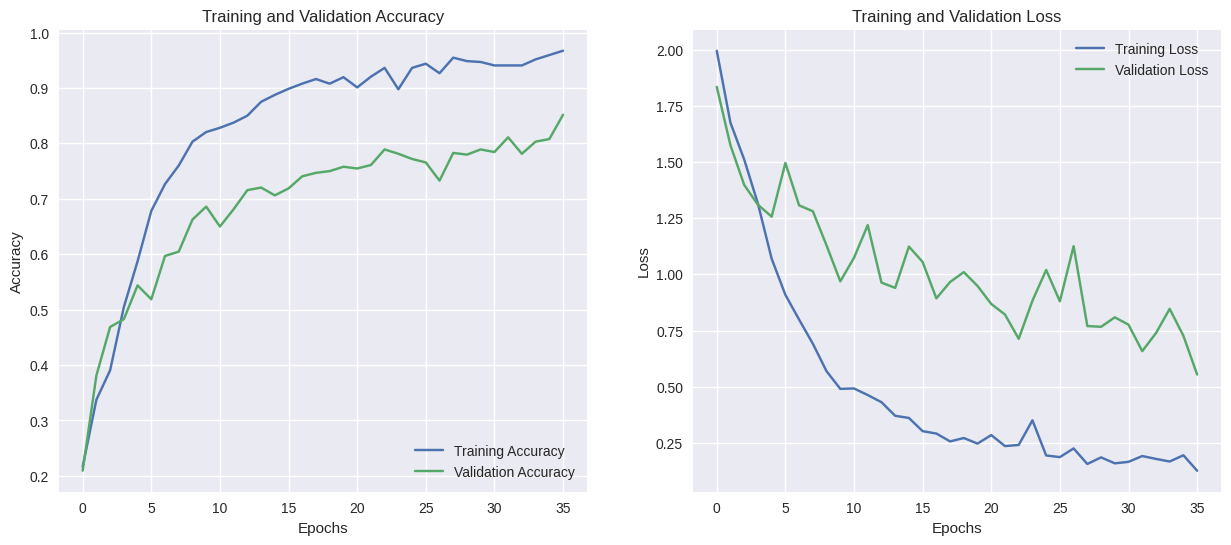

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**Testing Model**

In [19]:
print(train_generator.class_indices)

{'brown-glass': 0, 'green-glass': 1, 'metal': 2, 'plastic': 3, 'trash': 4, 'white-glass': 5}


Saving metal116.jpg to metal116.jpg
1/1 [==============================] - 3s 3s/step
metal116.jpg
metal


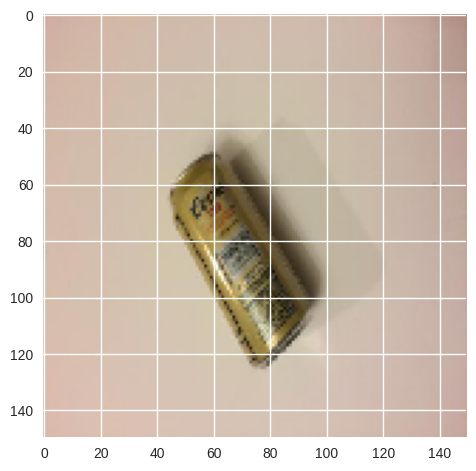

In [20]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(150, 150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=32)
  print(fn)
  if classes[0][0]==1:
    print('brown-glass')
  elif classes[0][1]==1:
    print('green-glass')
  elif classes[0][2]==1:
    print('metal')
  elif classes[0][3]==1:
    print('plastic')
  elif classes[0][4]==1:
    print('trash')
  elif classes[0][5]==1:
    print('white-glass')
  else:
    print('UNKNOWN')

**Menyimpan model dalam format SavedModel**

In [21]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

**Convert SavedModel menjadi vegs.tflite**

In [22]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

245408156